# Find Best Traces to Evaluate the Results

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dap.utils import obs_params, load_current
from dap import DAPcython

In [2]:
os.chdir('../')

In [3]:
from utils import calc_features_ramp, calc_features_step, find_spikes

## Load the Data 

#### Parameters

In [4]:
fname = 'dap_models_5_param_2x30.hdf'

df_steps = pd.read_hdf(fname, key='step_features')
df_ramps = pd.read_hdf(fname, key='ramp_features')
df_traces = pd.read_hdf(fname, key='param_traces')

In [5]:
df_traces.head(3)

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
Unnamed: 0,,,,,,,,,,
1x7,15.148030,1.019173,142.172834,3.410015,0.054763,488.716533,2103.298458,2592.014991,"[-74.99226118908273, -75.04159923573773, -75.0...","[-75.00303001398359, -74.99362755857885, -75.0..."
1x18,17.667796,1.083533,117.071599,3.596532,0.059960,930.301943,2628.593658,3558.895601,"[-75.00620678038246, -74.9033245368423, -74.86...","[-75.00945123905866, -74.98327821045316, -74.9..."
1x27,19.766811,1.016902,82.904896,3.719787,0.053818,1787.586622,2567.955205,4355.541827,"[-75.00485752261461, -74.91823785213174, -74.8...","[-74.99914121350989, -74.97828624219945, -74.9..."


In [6]:
df_traces.index.rename('id', inplace=True)
df_traces.reset_index(level=0, inplace=True)
df_traces.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
0,1x7,15.148030,1.019173,142.172834,3.410015,0.054763,488.716533,2103.298458,2592.014991,"[-74.99226118908273, -75.04159923573773, -75.0...","[-75.00303001398359, -74.99362755857885, -75.0..."
1,1x18,17.667796,1.083533,117.071599,3.596532,0.059960,930.301943,2628.593658,3558.895601,"[-75.00620678038246, -74.9033245368423, -74.86...","[-75.00945123905866, -74.98327821045316, -74.9..."
2,1x27,19.766811,1.016902,82.904896,3.719787,0.053818,1787.586622,2567.955205,4355.541827,"[-75.00485752261461, -74.91823785213174, -74.8...","[-74.99914121350989, -74.97828624219945, -74.9..."


#### Original Data

In [7]:
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

In [8]:
# calculate DAP
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

### Run Best Fit for Comparison

In [9]:
### Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U = dap.simulate(dtr, tr, Ir)
U_step = dap.simulate(dts, ts, Is)

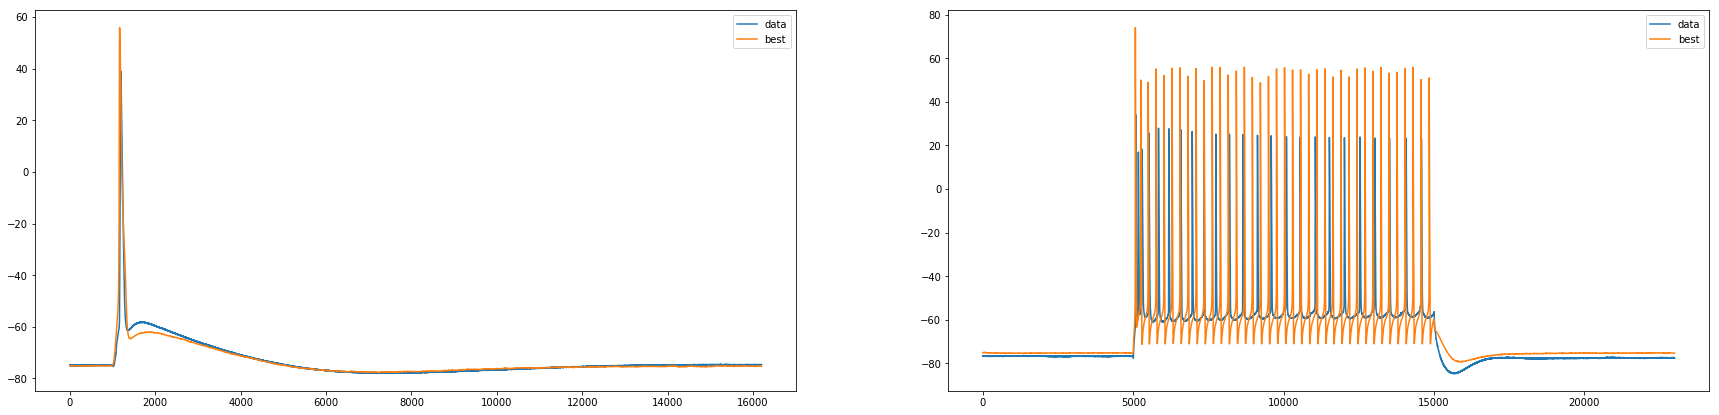

In [10]:
fig, ax  = plt.subplots(ncols=2, figsize=(30,7))
ax[0].plot(vr, label='data')
ax[0].plot(U, label='best')
ax[0].legend();

ax[1].plot(vs, label='data')
ax[1].plot(U_step, label='best');
ax[1].legend();

## Calculate The Features

In [11]:
data_feat_ramp = calc_features_ramp(vr, tr, dtr, t_onr, t_offr)
data_feat_ramp

array([-74.9345 , 113.997  ,   0.73   , -59.96875,  14.21575,  19.73   ,
        -0.75   ,   1.39   , -78.09375])

In [12]:
data_feat_step = calc_features_step(vs, ts, dts, t_ons, t_offs)
data_feat_step

array([-76.63358125, 0.06351057982730121, 48.0, 20.62173913043478,
       6.066798921122928, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ])],
      dtype=object)

## Create Comparison DF

#### Ramp Current

In [13]:
df_diff_ramps = np.abs(df_ramps.copy() - data_feat_ramp)
df_diff_ramps['sum'] = df_diff_ramps.sum(axis=1)
df_diff_ramps['sum'] = np.abs(df_diff_ramps['sum'])

df_diff_ramps.index.rename('id', inplace=True)
df_diff_ramps.reset_index(level=0, inplace=True)


#### Step Current

In [14]:
df_diff_steps = df_steps.dropna()
df_diff_steps.drop('spike_times_stim', axis=1, inplace=True)
df_diff_steps = np.abs(df_diff_steps - data_feat_step[:-1])

df_diff_steps.index.rename('id', inplace=True)
df_diff_steps.reset_index(level=0, inplace=True)
df_diff_steps['sum'] = df_diff_steps.drop('spike_count', axis=1).sum(axis=1)


/home/alteska/anaconda3/envs/dap2/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Pick The Best For Both Currents

In [30]:
n = 6
df_best_ramps = df_diff_ramps.sort_values('sum').head(n)
df_best_steps = df_diff_steps.sort_values('spike_count').head(n)

In [31]:
df_best_ramps

,id,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
5,1x29,0.032899,16.342078,0.01,4.882956,4.150935,0.24,0.764919,0.88,0.473338,27.777126
8,1x28,0.047287,16.365118,0.01,4.859374,4.087043,0.51,0.725044,0.84,0.380100,27.823967
30,1x21,0.043448,16.410755,0.01,4.631959,3.943804,0.84,0.731603,0.79,0.707441,28.109009
14,1x8,0.062579,15.992757,0.01,4.591034,4.535991,2.97,0.007536,0.76,0.147324,29.077220
3,1x26,0.854612,15.040753,0.02,4.733974,5.051735,0.01,0.536851,0.65,2.201061,29.098985
24,1x37,0.739379,15.429966,0.01,4.678685,4.927623,0.30,0.490441,0.71,1.846161,29.132254


In [32]:
df_best_steps

,id,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
23,1x23,0.882219,0.034433,0.0,0.510870,1.299437,0.0,2.726958
20,1x16,6.519965,0.031929,2.0,1.096443,5.477974,1.0,15.126311
22,1x37,3.695729,0.035383,2.0,0.757156,1.799152,1.0,8.287421
3,1x26,4.127413,0.020929,2.0,1.832806,1.128040,1.0,9.109188
32,1x22,8.201477,0.016437,2.0,1.173715,5.515373,1.0,16.907002
26,1x5,1.936787,0.026664,2.0,1.191897,1.191602,1.0,6.346950


## Merge With DFTraces to Get the best Traces and Parameters

In [33]:
names=['id','gbar_nap','gbar_leak','gbar_nat','gbar_kdr','gbar_hcn','ramp_traces', 'step_traces']

In [34]:
df_best_ramp_tr = pd.merge(df_traces, df_best_ramps)
df_best_ramp_tr.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,distance_ramp,distance_step,distance_sum,step_traces,...,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
0,1x26,17.427939,1.066976,125.792845,3.745146,0.054819,633.880514,2280.693478,2914.573992,"[-74.99144023355183, -74.97719776126465, -74.9...",...,0.854612,15.040753,0.02,4.733974,5.051735,0.01,0.536851,0.65,2.201061,29.098985
1,1x29,15.659854,1.030483,131.108312,3.288342,0.052816,461.131691,2475.512863,2936.644554,"[-75.01795946641855, -74.98913713122896, -75.0...",...,0.032899,16.342078,0.01,4.882956,4.150935,0.24,0.764919,0.88,0.473338,27.777126
2,1x28,16.247503,1.053526,130.858887,3.436357,0.047079,456.199910,2442.644972,2898.844882,"[-74.98981847675338, -75.0019720164376, -75.00...",...,0.047287,16.365118,0.01,4.859374,4.087043,0.51,0.725044,0.84,0.380100,27.823967


In [35]:
df_best_step_tr = pd.merge(df_traces, df_best_steps)[names]
df_best_step_tr

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,ramp_traces,step_traces
0,1x26,17.427939,1.066976,125.792845,3.745146,0.054819,"[-75.01165442727645, -75.02815830129136, -74.9...","[-74.99144023355183, -74.97719776126465, -74.9..."
1,1x16,17.443777,1.076104,104.080358,3.519479,0.054038,"[-75.00695928247188, -75.01103173363396, -74.9...","[-75.01466528322871, -74.97829050143098, -74.9..."
2,1x37,16.977066,1.026203,130.689112,3.626245,0.055480,"[-75.00579324534554, -74.95745866910103, -74.9...","[-74.97868052198699, -74.97891387517451, -74.9..."
3,1x23,15.474860,1.079514,135.661452,3.376905,0.052607,"[-74.99847046695515, -75.01815894401281, -75.0...","[-75.00011246580499, -75.00151629675561, -75.0..."
4,1x5,16.350748,1.085628,126.490642,3.512840,0.050621,"[-75.01878474813857, -74.9998777987758, -75.01...","[-75.00784040653694, -74.9844549623866, -74.96..."
5,1x22,18.608829,1.041585,115.392873,3.850912,0.051976,"[-74.98972678604396, -75.00891515790335, -74.9...","[-75.00440387248862, -74.93902635262542, -74.9..."


## Visualize Best Results of Given Batch

### Ramp Current

In [36]:
traces_ramp = df_best_ramp_tr.ramp_traces
traces_step = df_best_ramp_tr.step_traces
ids = df_best_ramp_tr.id

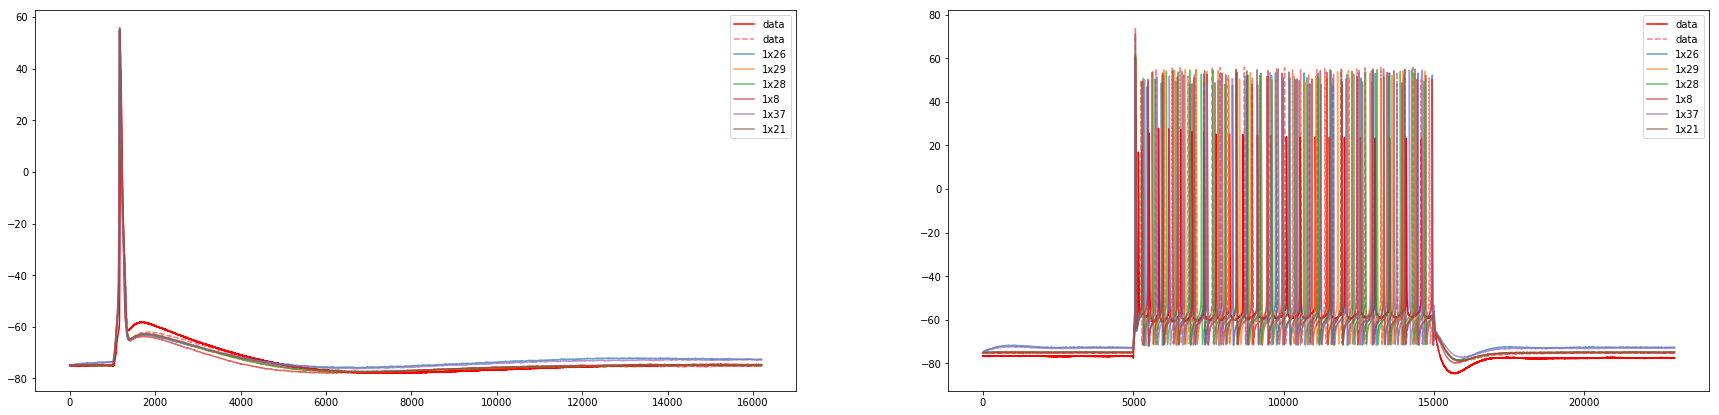

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[0].plot(U, 'r--', alpha=0.5, label='data');

ax[1].plot(vs, c='r', label='data');
ax[1].plot(U_step, 'r--', alpha=0.5, label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();



### Step Current

In [38]:
traces_ramp = df_best_step_tr.ramp_traces
traces_step = df_best_step_tr.step_traces
ids = df_best_step_tr.id

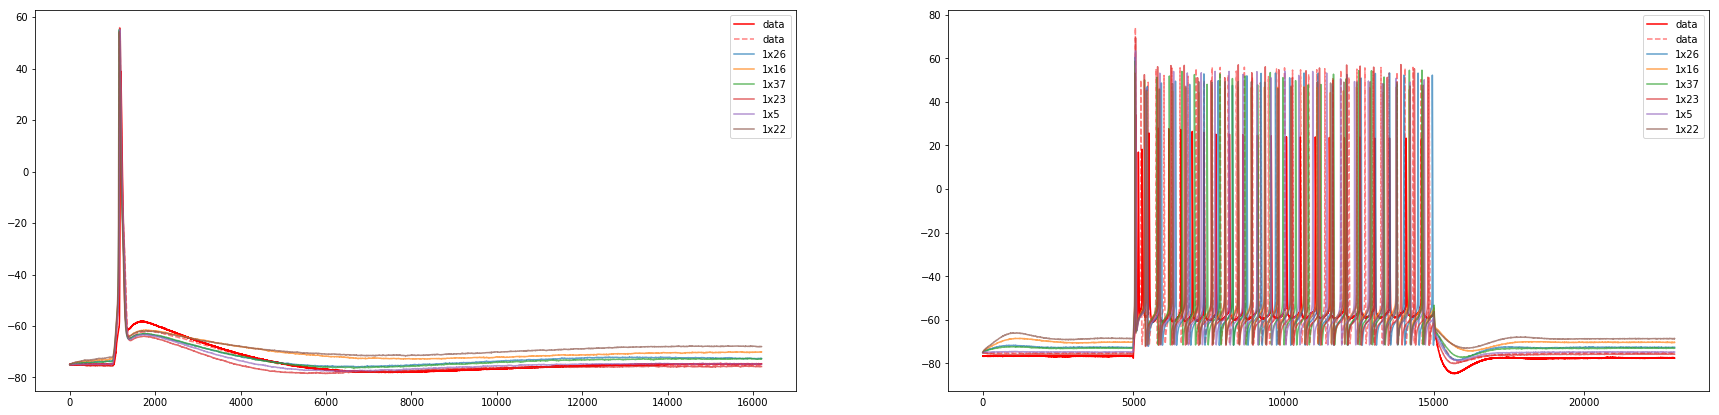

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[0].plot(U, 'r--', alpha=0.5, label='data');

ax[1].plot(vs, c='r', label='data');
ax[1].plot(U_step, 'r--', alpha=0.5, label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();


## Plot Distributions

In [40]:
# param_labels = ['id','gbar_nap', 'gbar_leak', 'gbar_nat', 'gbar_kdr']
param_labels = ['gbar_nap', 'gbar_leak', 'gbar_nat', 'gbar_kdr', 'gbar_hcn']

df = df_traces[param_labels]
df2 = df_best_step_tr[param_labels]

df['label'] = 0
df2['label'] = 1

/home/alteska/anaconda3/envs/dap2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/alteska/anaconda3/envs/dap2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


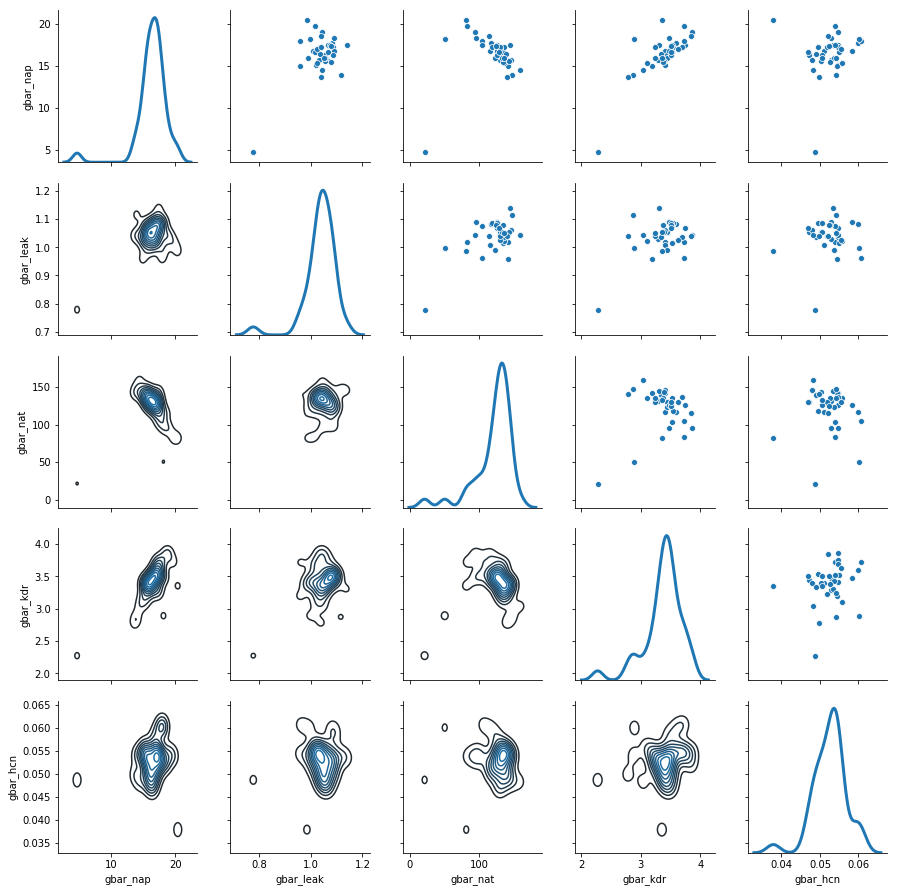

In [41]:
g = sns.PairGrid(df, vars=param_labels, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3);

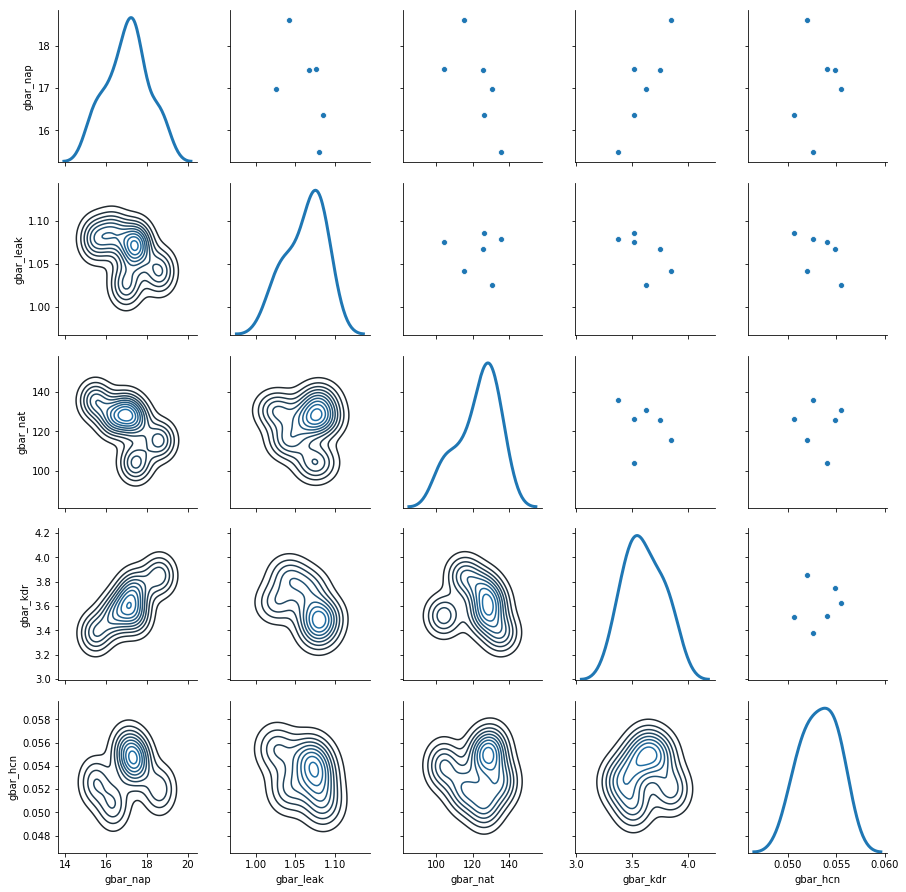

In [42]:
g2 = sns.PairGrid(df2, vars=param_labels, diag_sharey=False)
g2.map_lower(sns.kdeplot)
g2.map_upper(sns.scatterplot)
g2.map_diag(sns.kdeplot, lw=3)


In [43]:
df_double = pd.concat([df, df2])
df_double.head(3)

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,label
0,15.148030,1.019173,142.172834,3.410015,0.054763,0
1,17.667796,1.083533,117.071599,3.596532,0.059960,0
2,19.766811,1.016902,82.904896,3.719787,0.053818,0


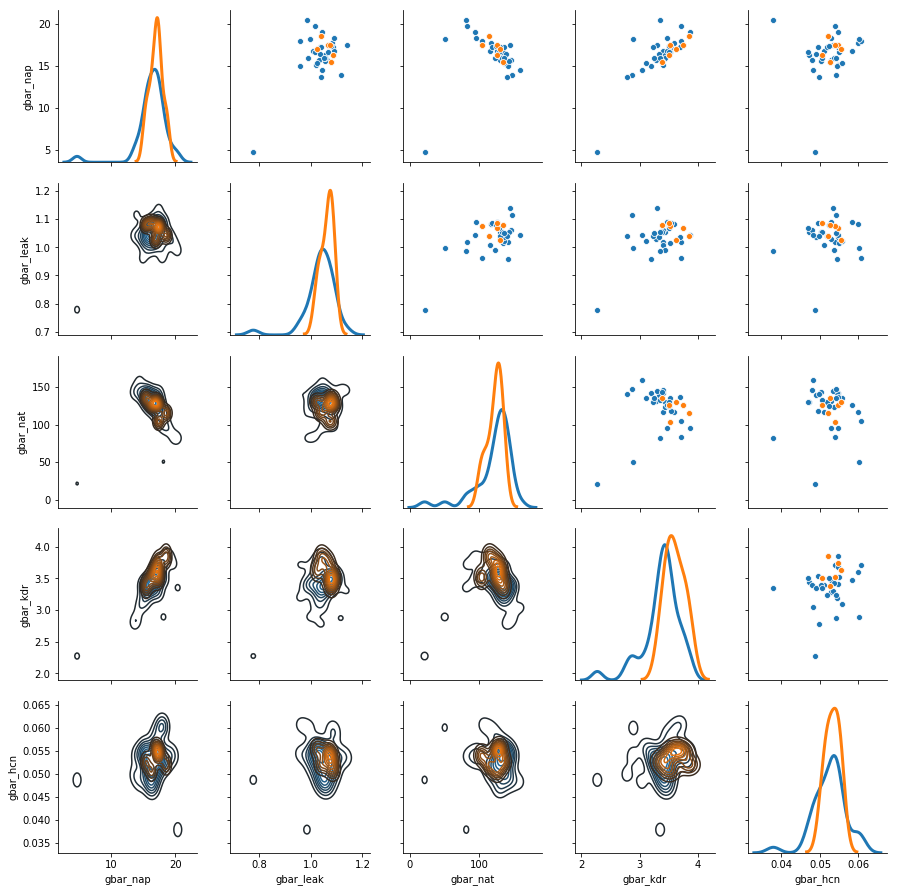

In [44]:
g3 = sns.PairGrid(df_double, vars=param_labels, hue='label', diag_sharey=False)
g3.map_lower(sns.kdeplot)
g3.map_upper(sns.scatterplot)
g3.map_diag(sns.kdeplot, lw=3)
